In [56]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import random
from copy import deepcopy
import gymnasium as gym

import os

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

# os.environ["SDL_VIDEODRIVER"] = "dummy"


def eval_agent(agent, env, n_sim=5):
    """
    ** Solution **

    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done:
            action = agent.get_action(state, 0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)


class Net(nn.Module):
    def __init__(self, input_channels, n_actions):
        super(Net, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduce size to half
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduce size to half again
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),  # Increased stride
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # Increased stride
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        # self.convs.add_module("Adaptive Pooling", nn.AdaptiveAvgPool2d((1, 1)))
        self.feature_size = 128  # directly set to 128 assuming you adaptively pooled to (1, 1) and have 128 channels

        # Calculate the output size after convolutions
        self.feature_size = self._get_conv_output((input_channels, 84, 84))

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 256),  # Use calculated feature size
            nn.ReLU(),
            nn.Linear(256, n_actions),
        )

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(1, *shape)  # simulate input
            output = self.convs(input)
            total_features = int(
                np.prod(output.size()[1:])
            )  # product of dimensions excluding the batch size
            # print(f"Calculated feature size for FC layer: {total_features}")
            return total_features

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        # print("x.size() : ", x.size())
        return self.fc(x)


class DQN:
    def __init__(
        self,
        env,
        action_space,
        observation_space,
        gamma,
        batch_size,
        buffer_capacity,
        update_target_every,
        epsilon_start,
        decrease_epsilon_factor,
        epsilon_min,
        learning_rate,
    ):
        self.env = env
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every

        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = (
            decrease_epsilon_factor  # larger -> more exploration
        )
        self.epsilon_min = epsilon_min

        self.learning_rate = learning_rate

        self.reset()

    def update(self, state, action, reward, terminated, next_state):
        """
        ** SOLUTION **
        """
        # Convert numpy arrays or lists to tensors and ensure they are floats
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        action_tensor = torch.tensor([[action]], dtype=torch.int64)
        reward_tensor = torch.tensor([reward], dtype=torch.float32)
        terminated_tensor = torch.tensor([terminated], dtype=torch.float32)

        # Store transition in the replay buffer
        self.buffer.push(
            state_tensor,
            action_tensor,
            reward_tensor,
            terminated_tensor,
            next_state_tensor,
        )

        # # add data to replay buffer
        # self.buffer.push(
        #     torch.tensor(state).unsqueeze(0),
        #     torch.tensor([[action]], dtype=torch.int64),
        #     torch.tensor([reward]),
        #     torch.tensor([terminated], dtype=torch.int64),
        #     torch.tensor(next_state, dtype=torch.float).unsqueeze(0),
        # )

        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = (
            tuple([torch.cat(data) for data in zip(*transitions)])
        )

        values = self.q_net.forward(state_batch).gather(1, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            next_state_values = (1 - terminated_batch) * self.target_net(
                next_state_batch
            ).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets.unsqueeze(1))

        # Optimize the model with gradient clipping
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1)  # Gradient clipping
        self.optimizer.step()

        # Soft update the target network
        for target_param, local_param in zip(
            self.target_net.parameters(), self.q_net.parameters()
        ):
            target_param.data.copy_(
                0.995 * target_param.data + 0.005 * local_param.data
            )

        self.scheduler.step()  # Step through the scheduler

        if not ((self.n_steps + 1) % self.update_target_every):
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.decrease_epsilon()

        self.n_steps += 1
        if terminated:
            self.n_eps += 1

        return loss.detach().numpy()

    def get_action(self, state, epsilon=None):
        """
        Return action according to an epsilon-greedy exploration policy
        """
        if epsilon is None:
            epsilon = self.epsilon

        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.get_q(state))

    def get_q(self, state):
        """
        Compute Q function for a states
        """
        state_tensor = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        with torch.no_grad():
            output = self.q_net.forward(state_tensor)  # shape (1,  n_actions)
        return output.numpy()[0]  # shape  (n_actions)

    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
            np.exp(-1.0 * self.n_eps / self.decrease_epsilon_factor)
        )

    def reset(self):
        input_channels = self.observation_space.shape[
            0
        ]  # Assuming observation space is image-based
        n_actions = self.action_space.n

        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net = Net(input_channels, n_actions)
        self.target_net = Net(input_channels, n_actions)
        self.target_net.load_state_dict(
            self.q_net.state_dict()
        )  # Initialize target net
        self.target_net.eval()  # Set target net to eval mode

        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(
            params=self.q_net.parameters(), lr=self.learning_rate, weight_decay=1e-5
        )
        self.scheduler = StepLR(
            self.optimizer, step_size=100, gamma=0.99
        )  # Learning rate scheduler

        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0

    def save(self, filename):
        """
        Save the current model parameters to the specified file.
        """
        torch.save(
            {
                "q_net_state_dict": self.q_net.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "scheduler_state_dict": self.scheduler.state_dict(),
                "epsilon": self.epsilon,
                "n_steps": self.n_steps,
                "n_eps": self.n_eps,
            },
            filename,
        )
        print(f"Model saved to {filename}")

    def load(self, filename):
        """
        Load model parameters from the specified file.
        """
        checkpoint = torch.load(filename)
        self.q_net.load_state_dict(checkpoint["q_net_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        self.epsilon = checkpoint["epsilon"]
        self.n_steps = checkpoint["n_steps"]
        self.n_eps = checkpoint["n_eps"]
        self.target_net.load_state_dict(self.q_net.state_dict())
        print(f"Model loaded from {filename}")


def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done:
        action = agent.get_action(state, 0)
        state, reward, done, _, _ = display_env.step(action)
        rewards += reward
        if display:
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f"Episode length {rewards}")


def run_episodes_for_a_minute(env, agent, display=True):
    start_time = time.time()
    episodes = 0
    total_rewards = 0

    while time.time() - start_time < 10:  # Exécuter pendant environ une minute
        state, _ = env.reset()
        done = False
        episode_rewards = 0

        while not done:
            action = agent.get_action(state, 0)
            state, reward, done, _, _ = env.step(action)
            episode_rewards += reward
            if display:
                # clear_output(wait=True)
                # plt.imshow(env.render())
                # plt.show()
                env.render()

        episodes += 1
        total_rewards += episode_rewards
        print(f"Episode {episodes} reward: {episode_rewards}")

    print(f"Nombre total d'épisodes exécutés en 1 minute : {episodes}")
    print(f"Récompense moyenne sur les épisodes : {total_rewards / episodes}")


# env = env = gym.make("CartPole-v1", render_mode="rgb_array")
# agent = RandomAgent(env.observation_space, env.action_space)

# # Exécuter la fonction pour des épisodes répétés pendant environ une minute
# run_episodes_for_a_minute(env, agent)

# # run_one_episode(env, agent, display=True)
# print(f"Average over 5 runs : {np.mean(eval_agent(agent, env))}")

In [57]:
def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    state, _ = env.reset()
    losses = []
    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            loss_val = agent.update(state, action, reward, terminated, next_state)

            state = next_state
            losses.append(loss_val)

            done = terminated or truncated
            total_time += 1

        if (ep + 1) % eval_every == 0:
            rewards = eval_agent(agent, env)
            print("episode =", ep + 1, ", reward = ", np.mean(rewards))
            if np.mean(rewards) >= reward_threshold:
                break

    return losses

episode = 10 , reward =  5.239034265258679
episode = 20 , reward =  11.67119165076281
episode = 30 , reward =  9.95625
episode = 40 , reward =  8.9375
episode = 50 , reward =  6.825
episode = 60 , reward =  5.55625
episode = 70 , reward =  8.8625
episode = 80 , reward =  5.04375
episode = 90 , reward =  7.923862958010746
episode = 100 , reward =  4.513400797742806
episode = 110 , reward =  6.246636165748692
episode = 120 , reward =  9.546191650762811
episode = 130 , reward =  3.674073156858978
episode = 140 , reward =  6.825
episode = 150 , reward =  5.0625
episode = 160 , reward =  8.684136165748692
episode = 170 , reward =  10.0625
episode = 180 , reward =  2.9375
episode = 190 , reward =  9.121636165748692
episode = 200 , reward =  10.5
episode = 210 , reward =  2.516825398871403
episode = 220 , reward =  8.986362958010746
episode = 230 , reward =  7.112698611634713
episode = 240 , reward =  3.7625
episode = 250 , reward =  6.861362958010747
episode = 260 , reward =  5.825
episode =

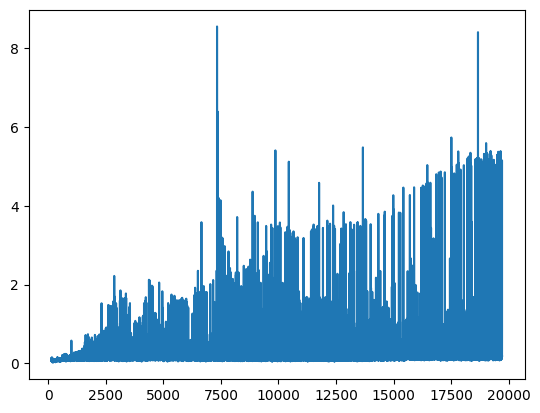

In [58]:
# Adjusted environment initialization for "highway-fast-v0"
import gymnasium as gym
from gymnasium import spaces
from config import config

# Configure and create the environment
env = gym.make("highway-fast-v0", render_mode="rgb_array", config=config)
action_space = env.action_space
observation_space = env.observation_space

# Update the DQN Agent initialization with the new action and observation spaces
# Note: Ensure that observation dimensions are correctly handled within your DQN architecture.
# This might require adjustments depending on how the "OccupancyGrid" observations are structured.

# Hyperparameters might need adjustment based on the new environment dynamics.
gamma = 0.99
batch_size = 128
buffer_capacity = 20_000
update_target_every = 32
epsilon_start = 0.9
decrease_epsilon_factor = 1500
epsilon_min = 0.01
learning_rate = 1e-3

hidden_size = 256
n_actions = env.action_space.n

# When you instantiate the DQN agent:
agent = DQN(
    env,
    action_space,
    observation_space,
    gamma,
    batch_size,
    buffer_capacity,
    update_target_every,
    epsilon_start,
    decrease_epsilon_factor,
    epsilon_min,
    learning_rate,
)

# Training might need adjustments, especially evaluation metrics and thresholding for success.
N_episodes = 1000

# Proceed with the adjusted training function
# Ensure that your training and evaluation routines properly handle the updated environment observations and actions.
losses = train(env, agent, N_episodes)
agent.save("dqn_agent_2_1000.pth")
plt.plot(losses)

In [40]:
# Load the trained agent
from config import config
import gymnasium as gym
from gymnasium import spaces

env = gym.make("highway-fast-v0", render_mode="rgb_array", config=config)
action_space = env.action_space
observation_space = env.observation_space

# Update the DQN Agent initialization with the new action and observation spaces
# Note: Ensure that observation dimensions are correctly handled within your DQN architecture.
# This might require adjustments depending on how the "OccupancyGrid" observations are structured.

# Hyperparameters might need adjustment based on the new environment dynamics.
gamma = 0.99
batch_size = 128
buffer_capacity = 20_000
update_target_every = 32
epsilon_start = 0.9
decrease_epsilon_factor = 1500
epsilon_min = 0.01
learning_rate = 1e-4

hidden_size = 256
n_actions = env.action_space.n

# When you instantiate the DQN agent:
agent = DQN(
    env,
    action_space,
    observation_space,
    gamma,
    batch_size,
    buffer_capacity,
    update_target_every,
    epsilon_start,
    decrease_epsilon_factor,
    epsilon_min,
    learning_rate,
)

agent.load("dqn_agent_3000.pth")

Calculated feature size for FC layer: 4608
Calculated feature size for FC layer: 4608


RuntimeError: Error(s) in loading state_dict for Net:
	Missing key(s) in state_dict: "convs.0.weight", "convs.0.bias", "convs.3.weight", "convs.3.bias", "convs.6.weight", "convs.6.bias", "convs.8.weight", "convs.8.bias", "fc.0.weight", "fc.0.bias", "fc.2.weight", "fc.2.bias". 
	Unexpected key(s) in state_dict: "net.0.weight", "net.0.bias", "net.2.weight", "net.2.bias". 

In [59]:
# Evaluate the final policy
rewards = eval_agent(agent, env, 20)
print("")
print("mean reward after training = ", np.mean(rewards))


mean reward after training =  10.828125


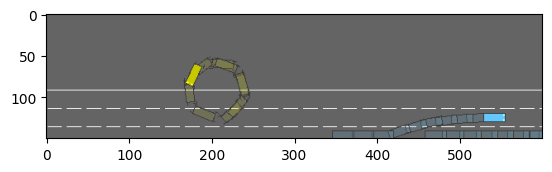

In [60]:
# env = gym.make('highway-v0', render_mode='rgb_array')
state = env.reset()
for _ in range(1):
    state = env.reset()
    # action = env.action_type.actions_indexes["IDLE"]
    # print(state)
    action = agent.get_action(state)
    # print(action)
    state, reward, done, _, _ = env.step(action)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render())
plt.show()

In [62]:
while True:
    done = truncated = False
    obs = env.reset()
    while not (done or truncated):
        action = agent.get_action(obs)
        obs, reward, done, truncated, info = env.step(action)
        env.render()

/var/folders/zk/rcqnm5cj1s31mwy0myzr5df00000gp/T/ipykernel_52822/736564058.py:242: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  state_tensor = torch.tensor(state, dtype=torch.float).unsqueeze(0)


ValueError: expected sequence of length 7 at dim 1 (got 4)